## Abstract

2020年11月份的数据。

探索疫情环境下，哪些Airbnb租的更好呢？哪些特征影响房屋的租赁情况呢？ 这篇文章将会得出最影响Airbnb房屋租赁的房屋特征，来帮助投资公司进行投资。

探索的问题：哪些特征对房屋的出租情况有显著性影响？


# 1. Reproducible Analysis

**Processes of data loading, data preprocessing, and data analysis**

> - Import Data
>> 1. 202011listings: Contains all London Airbnb rentals for November 2020
>> 2. uk-daily-covid-cases-7day-average：Contains information on Covid cases in various regions of the UK, from 2020 to 2022.
https://hidden-london.com/miscellany/covid-19-in-london/
> - Data Preprocessing
>> - Data preprocessing for the first dataset
>>> 1. Check missing values. There are four columns with all null values, so I decide to delete these columns directly (note that only the columns with all null values are deleted in this part, and the remaining columns will be processed in subsequent steps)
>>> 2. Check the spatial information (lat, long) of these houses to see if these houses are among the 32 Boroughs of London. In this part, I use the visualization + "GeoSeries.contains()" method of Geopandas.
>>>> - First draw a map, and display these houses in the form of points on the map through latitude and longitude coordinates. In the picture, I found that most of the houses are in the 32 Boroughs, but I can't accurately judge how many houses are not in the Boroughs.
>>>> - Secondly, I decided to use the GeoSeries.contains() method to judge whether the latitude and longitude are within the 32 Boroughs boundaries. Finally found that a few are not in it, so I decide to delete these houses.
>> - Data preprocessing for the second dataset
>>> 1. Check missing values
>>> 2. Data Transformation
>>>> - Since the data is from 2020 to 2022 and the first dataset is the Airbnb data in November 2020, therefore need do data transformation to filter dataset, only the data in November 2020 is retained
>>>> - Since the data is for all regions of the UK, it needs to be filtered to keep only the records in 32 London Boroughs.
>> - Combine the first and the second dataframe
>> - Data Transformation
>>> 1. Visualizing the availability_365 column shows that the distribution is extremely uneven and the data needs to be resampled. Before resampling, I need to calculate how many samples to take proportionally to each part
>>>> - Normalization: "stats.boxcox" method. Boxcox method normalizes the data distribution. Boxcox can reduce the skewness and achieve the goal of approaching the normal distribution. The output of this step is to calculate how many samples need to be taken for resampling. However, due to the limitation of this method, the output number is between 1 and 3, and the number of decimal places is particularly large, so it is impossible to confirm how many samples need to be taken for each part. (The number of samples must be an integer. If these float numbers are converted to integer int, the number of samples for each part will be 1, 2, and 3, which does not reflect the distribution of the original data.)
>>>> - MIN-MAX scaling：The Min-Max method normalizes the number of samples to the interval 0 to 6 without changing the distribution.
After calculating how many samples need to be taken proportionally to each part, resample the data using undersampling method. Sample using dataframe.sample(n=just computed above)
>>> 2. After calculating how many samples need to be taken proportionally to each part, resample the data using undersampling method. Sample using dataframe.sample(n=just computed above)
>> - After sampling, I will perform feature selection method on the data to find out which features have a significant impact on the rental situation
>>> 1. Using the dataframe.info() method, it is found that the type of the data column is wrong. For example, the availability_365 column should be a number, but in dataframe it is an object, therefore the format needs to be converted.
>>> 2. Feature selection also requires that the data must be numeric, so the non-numeric columns are transformed
>>> 3. Since the feature selection method requires that the data cannot have NaN values, I need to check if there are NaN values. There are more than 200 empty values in 9 columns of data, because there are not many, I choose to delete them
> - Now the data is prepared, I use SelectKBest in sklearn.feature_selection to perform feature selection on the data.

## Import Libraries

In [2]:
"""
Import Libraries
"""
import numpy as np
import pandas as pd
import geopandas as gpd
# For visulisation purpose
import matplotlib.pyplot as plt
import seaborn as sns

# For box cox normalization
from scipy import stats

# For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# For Lasso linear model with iterative fitting along a regularization path.
from sklearn.linear_model import LassoCV

## Import Data

### Import First Dataset

In [12]:
# Import the first dataset
dfDirty = pd.read_csv('https://github.com/ShengweiDeng/i2p/releases/download/Data/202011listings.csv?raw=true')

URLError: <urlopen error [WinError 10061] 由于目标计算机积极拒绝，无法连接。>

In [3]:
# Since there are more than 70 columns, the default is not to display the full number of columns. So I set it to show all the columns.
pd.set_option("display.max_columns",None)
dfDirty.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201106040109,2020-11-07,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Cable TV"", ""Coffee maker"", ""Carbon monoxide ...",$97.00,7,190,7,28,1125,1125,8.4,1125.0,NaN,t,0,0,4,279,2020-11-07,192,7,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.48


In [4]:
# Display the number of rows and columns of data
print("Number of Rows：%d, Number of Columns：%d"%(dfDirty.shape[0],dfDirty.shape[1]) )

Number of Rows：76984, Number of Columns：74


### Import Second Dataset

In [13]:
# Import the second dataset
dfCases = pd.read_csv('https://github.com/ShengweiDeng/i2p/raw/main/uk-daily-covid-cases-7day-average.csv?raw=true')

URLError: <urlopen error [WinError 10061] 由于目标计算机积极拒绝，无法连接。>

In [6]:
# Display the first two rows of dataframe
dfCases.head(2)

,Entity,Code,Day,daily_cases_rate_rolling_average
0,Aberdeen City,NaN,2020-08-05,7.228571
1,Aberdeen City,NaN,2020-08-06,8.800000


In [7]:
# Display the number of rows and columns of data
print("Number of Rows：%d, Number of Columns: %d"%(dfCases.shape[0],dfCases.shape[1]))

Number of Rows：134786, Number of Columns: 4


## Data Preprocessing

### Data preprocessing for the first dataset

> 1. Check missing values. There are four columns with all null values, so I decide to delete these columns directly (note that only the columns with all null values are deleted in this part, and the remaining columns will be processed in subsequent steps)

> 2. Check the spatial information (lat, long) of these houses to see if these houses are among the 32 Boroughs of London. In this part, I use the visualization + "GeoSeries.contains()" method of Geopandas.
>> - First draw a map, and display these houses in the form of points on the map through latitude and longitude coordinates. In the picture, I found that most of the houses are in the 32 Boroughs, but I can't accurately judge how many houses are not in the Boroughs.
>> - Secondly, I decided to use the GeoSeries.contains() method to judge whether the latitude and longitude are within the 32 Boroughs boundaries. Finally found that a few are not in it, so I decide to delete these houses.

**1. Check missing values**

In [8]:
"""
First check the entire Dataframe for missing values
"""
dfDirty.isnull().values.any()

True

I found in the previous step that there are nulls in the first Dataframe, so I decided to look at how many missing values exist in each column

In [9]:
"""
Find out how many missing values exist in each column
"""
# Count the number of missing values in each column and create a new Dataframe based on the results
dfDirtyCheck0 = pd.DataFrame(dfDirty.isnull().sum().rename_axis('Column_Name').reset_index(name='NaN_Counts'))

# Sort this new Dataframe from largest to smallest according to column "NaN_Counts" column
dfDirtyCheck0 = dfDirtyCheck0.sort_values(["NaN_Counts"], ascending=False)
dfDirtyCheck0.head(5)

,Column_Name,NaN_Counts
28,neighbourhood_group_cleansed,76984
67,license,76984
34,bathrooms,76984
48,calendar_updated,76984
14,host_response_time,37618


According to the previous steps, this dataset has a total of 76984 records. From the above results, it is found that the four columns "neighbourhood_group_cleansed", "license", "bathrooms" and "calendar_updated" are all empty values, so I decided to delete these four columns . The remaining columns, if used in subsequent steps, I will handle for null values in subsequent steps.

In [10]:
"""
Remove the "neighbourhood_group_cleansed", "license", "bathrooms" and "calendar_updated" columns that are all nulls.
"""
dfDirty.drop(["neighbourhood_group_cleansed", "license", "bathrooms", "calendar_updated"], axis=1, inplace=True)

In [11]:
"""
Check whether these four columns are deleted successfully
"""
# Count the number of missing values in each column and create a new Dataframe based on the results
dfDirtyCheck1 = pd.DataFrame(dfDirty.isnull().sum().rename_axis('Column_Name').reset_index(name='NaN_Counts'))
# Sort this new Dataframe from largest to smallest according to column "NaN_Counts" column
dfDirtyCheck1 = dfDirtyCheck1.sort_values(["NaN_Counts"], ascending=False)
dfDirtyCheck1.head(5)

,Column_Name,NaN_Counts
15,host_response_rate,37618
14,host_response_time,37618
13,host_about,33765
6,neighborhood_overview,29148
26,neighbourhood,29147


These four columns are deleted successfully. The remaining columns, if used in subsequent steps, I will handle them at that step.

**2. Check the spatial information (lat, long) of these records**

In this step, I will check the spatial information (lat, long) of these houses to see if these houses are among the 32 Boroughs of London. I will use the visualization + "GeoSeries.contains()" method of Geopandas.

Visually determine whether these housing records are within the 32 boroughs of London.

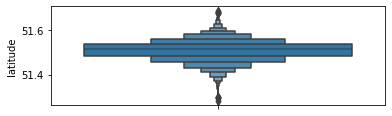

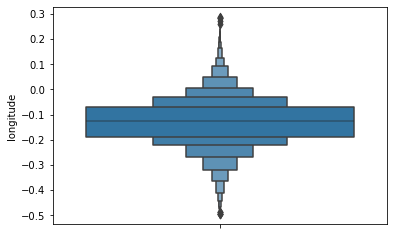

In [12]:
"""
First draw a boxplot of the latitude and longitude of the house to see if the distribution is reasonable.
"""

f=plt.figure()
f.add_subplot(2,1,1)
# Draw the first boxplot for latitude
sns.boxenplot(y = dfDirty.latitude)
plt.show()

f.add_subplot(2,1,2)
# Draw the second boxplot for longitude
sns.boxenplot(y = dfDirty.longitude)
plt.show()

In the above figure, it can be seen that the location distribution of houses （according to Latitude and Longitude） is uneven, and there are obviously more houses in some areas than in other areas.

Next, it was decided to draw the distribution of all the houses on a map drawn by Geopandas.

In [14]:
"""
Boroughs Datasets contains geospatial information for the 32 autonomous states of London
"""

#boroughs Datasets contains geospatial information for the 32 autonomous states of London
boroughs = gpd.read_file('https://github.com/ShengweiDeng/i2p/raw/Data/Boroughs.gpkg?raw=true')

# gdf is also a Dataframe, which is the column of dfDirty + an extra column which converts each group of latitude and longitude into a point in space
gdf = gpd.GeoDataFrame(dfDirty,geometry=gpd.points_from_xy(dfDirty.longitude, dfDirty.latitude,crs='epsg:4326')).to_crs('epsg:27700')

URLError: <urlopen error [WinError 10061] 由于目标计算机积极拒绝，无法连接。>

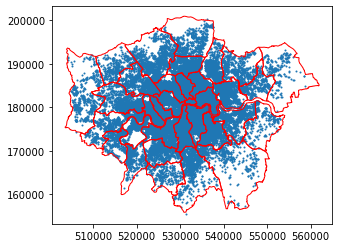

In [14]:
"""
Plot all houses in the map of London
"""

# The role of this is to draw a scatter plot in the coordinate system
axis=gdf.plot(marker = 'o', markersize=1)

# The role of this is to add a boundary of 32 London Boroughs to the scatter plot above
boroughs.plot(ax=axis, facecolor='none', edgecolor='r')
plt.show()

We can see in the above figure that each point seems to be in the boundaries of 32 boroughs, but it is hard to define which houses are not in the boundary. So I decided to use the GeoSeries.contains() function to check which houses are not in the boundary of 32 London Boroughs.

In [15]:
"""
Use a For loop to traverse all the data. 
If the latitude and longitude information of this piece of data is within the boundary of 32 London Boroughs, 
add the name of the Borough to this list, if not, add a NaN value.
"""
listBoroughs = []
for i in gdf.geometry:
    listBoroughs.append(list(boroughs[boroughs["geometry"].contains(i)].NAME))

In [16]:
"""
Previous step: If this piece of data is within the boundary of 32 London Boroughs, add the Borough's name to this list, 
if not, add a NaN value.

This step: If there is a NaN value, it means that this data is not in London, therefore I mark it as Error.
Then add a new column to the original Dataframe, which contains the Borough name based on Lat and Long.
"""

AirbnbBoroughs = []

for i in listBoroughs:
    # Check for NaN values, if it is NaN values, means this data is not in 32 London Boroughs, mark it to Error:
    # If it is not NaN value, means that this data is in 32 London Boroughs, add this Borough Name to list.
    if len(i) > 0:
        AirbnbBoroughs.append(i[0])
    else:
        AirbnbBoroughs.append("Error")

# Create a new column of dataframe
dfDirty['Boroughs'] = AirbnbBoroughs
dfDirty["Boroughs"].value_counts()

Westminster               8576
Tower Hamlets             6829
Hackney                   5721
Kensington and Chelsea    5329
Camden                    5258
Islington                 4489
Lambeth                   4406
Southwark                 4330
Wandsworth                3944
Hammersmith and Fulham    3574
Brent                     2338
Lewisham                  2174
Haringey                  2120
Newham                    1855
Ealing                    1673
Barnet                    1643
Greenwich                 1583
Waltham Forest            1372
Merton                    1249
Richmond upon Thames      1134
Croydon                   1109
Hounslow                  1034
Redbridge                  692
Enfield                    685
Hillingdon                 627
Bromley                    579
Kingston upon Thames       511
Harrow                     451
City of London             448
Barking and Dagenham       405
Sutton                     302
Bexley                     273
Havering

Based on the output above, there are 18 houses that are not located in 32 Boroughs of London. So I decide to delete them directly.

In [17]:
"""
Delete the 18 listings above that do not belong to London Boroughs
"""
dfDirty = dfDirty.drop(index=(dfDirty.loc[(dfDirty['Boroughs']=='Error')].index))
dfDirty["Boroughs"].value_counts()

Westminster               8576
Tower Hamlets             6829
Hackney                   5721
Kensington and Chelsea    5329
Camden                    5258
Islington                 4489
Lambeth                   4406
Southwark                 4330
Wandsworth                3944
Hammersmith and Fulham    3574
Brent                     2338
Lewisham                  2174
Haringey                  2120
Newham                    1855
Ealing                    1673
Barnet                    1643
Greenwich                 1583
Waltham Forest            1372
Merton                    1249
Richmond upon Thames      1134
Croydon                   1109
Hounslow                  1034
Redbridge                  692
Enfield                    685
Hillingdon                 627
Bromley                    579
Kingston upon Thames       511
Harrow                     451
City of London             448
Barking and Dagenham       405
Sutton                     302
Bexley                     273
Havering

In [18]:
dfDirty.shape[0]

76966

### Data preprocessing for the second dataset

> 1. Check missing values
> 2. Data Transformation
>> - Since the data is from 2020 to 2022 and the first dataset is the Airbnb data in November 2020, therefore need do data transformation to filter dataset,  only the data in November 2020 is retained
>> - Since the data is for all regions of the UK, it needs to be filtered to keep only the records in 32 London Boroughs.

In [19]:
"""
Check if the dataset has missing values
"""
dfCases.isnull().values.any()

True

There are missing values in this dataset.

In [20]:
"""
Find out how many missing values exist in each column
"""
# Count the number of missing values in each column and create a new Dataframe based on the results
dfCheck = pd.DataFrame(dfCases.isnull().sum().rename_axis('Column_Name').reset_index(name='NaN_Counts'))
# Sort this new Dataframe from largest to smallest according to column "NaN_Counts" column
dfCheck = dfCheck.sort_values(["NaN_Counts"], ascending=False)
dfCheck

,Column_Name,NaN_Counts
1,Code,134091
0,Entity,0
2,Day,0
3,daily_cases_rate_rolling_average,0


It is found that the "Code" column is basically empty, and this information is not important. So I just delete it

In [21]:
"""
It is found that the Code column is basically empty, and this information is not important. So just delete it
"""
dfCases.drop(["Code"], axis=1, inplace=True)

In [22]:
dfCases

,Entity,Day,daily_cases_rate_rolling_average
0,Aberdeen City,2020-08-05,7.228571
1,Aberdeen City,2020-08-06,8.800000
2,Aberdeen City,2020-08-07,9.728571
3,Aberdeen City,2020-08-08,10.228571
4,Aberdeen City,2020-08-09,10.357143
...,...,...,...
134781,York,2022-01-19,125.585714
134782,York,2022-01-20,124.100000
134783,York,2022-01-21,125.585714
134784,York,2022-01-22,126.871429


**Data Tranformation: Filter data for November 2020 to match the information in the first Dataframe**

In [23]:
"""
1. Convert the Day column to Datetime type.
"""

dfCases['Day'] = pd.to_datetime(dfCases['Day'])

In [24]:
"""
Create a new column that only contains year
"""
dfCases['year'] = dfCases['Day'].dt.year

In [25]:
"""
Filter the whole datasets that only contains records in 2020.
"""
dfCases2020 = dfCases[dfCases['year'] == 2020]

In [26]:
dfCases2020

,Entity,Day,daily_cases_rate_rolling_average,year
0,Aberdeen City,2020-08-05,7.228571,2020
1,Aberdeen City,2020-08-06,8.800000,2020
2,Aberdeen City,2020-08-07,9.728571,2020
3,Aberdeen City,2020-08-08,10.228571,2020
4,Aberdeen City,2020-08-09,10.357143,2020
...,...,...,...,...
134393,York,2020-12-27,42.985714,2020
134394,York,2020-12-28,46.314286,2020
134395,York,2020-12-29,54.700000,2020
134396,York,2020-12-30,61.885714,2020


In [27]:
"""
Create a new column that only contains month
"""
dfCases2020['month'] = dfCases2020['Day'].dt.month

C:\Users\lingc\AppData\Local\Temp/ipykernel_373040/2822959378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCases2020['month'] = dfCases2020['Day'].dt.month


In [28]:
"""
Filter the 2020 records that only contains records in November.
"""
dfCases202011 = dfCases2020[dfCases2020['month'] == 11]

In [29]:
dfCases202011

,Entity,Day,daily_cases_rate_rolling_average,year,month
88,Aberdeen City,2020-11-01,5.742857,2020,11
89,Aberdeen City,2020-11-02,6.800000,2020,11
90,Aberdeen City,2020-11-03,6.242857,2020,11
91,Aberdeen City,2020-11-04,6.357143,2020,11
92,Aberdeen City,2020-11-05,5.171429,2020,11
...,...,...,...,...,...
134362,York,2020-11-26,14.085714,2020,11
134363,York,2020-11-27,12.257143,2020,11
134364,York,2020-11-28,11.442857,2020,11
134365,York,2020-11-29,10.357143,2020,11


**Filtering boroughs, only keep records in 32 boroughs of London.**

In [30]:
# Get the borough Name
boroughName = list(boroughs.NAME)
boroughName.append("Hackney and City of London")

In [31]:
"""
Filter the data. Only keep records in 32 boroughs of London.
"""
dfCases202011 = dfCases202011[dfCases202011['Entity'].isin(boroughName)]
dfCases202011

,Entity,Day,daily_cases_rate_rolling_average,year,month
3888,Barking and Dagenham,2020-11-01,23.885714,2020,11
3889,Barking and Dagenham,2020-11-02,25.357143,2020,11
3890,Barking and Dagenham,2020-11-03,27.157143,2020,11
3891,Barking and Dagenham,2020-11-04,27.485714,2020,11
3892,Barking and Dagenham,2020-11-05,29.085714,2020,11
...,...,...,...,...,...
128635,Westminster,2020-11-26,13.714286,2020,11
128636,Westminster,2020-11-27,13.400000,2020,11
128637,Westminster,2020-11-28,13.442857,2020,11
128638,Westminster,2020-11-29,12.871429,2020,11


In [32]:
"""
Count the number of cases by using groupby method.
"""
# Group by Boroughs
dfCasesProcessed = dfCases202011.groupby('Entity').sum().reset_index()
dfCasesProcessed.drop(["year","month"], axis=1, inplace=True)
# By observation, the original data merged the two regions of Hackney and city of london, so I neet to split them here
dfCasesProcessed = dfCasesProcessed.append({'Entity': "Hackney", "daily_cases_rate_rolling_average":317}, ignore_index=True)
dfCasesProcessed = dfCasesProcessed.append({'Entity': "City of London", "daily_cases_rate_rolling_average":317}, ignore_index=True)
dfCasesProcessed = dfCasesProcessed.drop(index=(dfCasesProcessed.loc[(dfCasesProcessed['Entity']=='Hackney and City of London')].index))

In [33]:
dfCasesProcessed = dfCasesProcessed.rename(columns = {"Entity": "Boroughs"})

In [34]:
dfCasesProcessed

,Boroughs,daily_cases_rate_rolling_average
0,Barking and Dagenham,1021.671429
1,Barnet,666.528571
2,Bexley,982.285714
3,Brent,792.428571
4,Bromley,579.557143
5,Camden,446.500000
6,Croydon,597.200000
7,Ealing,927.400000
8,Enfield,779.714286
9,Greenwich,654.842857


### Combine first and second Dataframe


In [35]:
"""
According to the Borough name of the first Dataframe, 
add the Covid cases of Borough corresponding to the second Dataframe to the first Dataframe.
"""

listOfCases = []


# First create a dictionary, key is boroughs, value is the corresponding Covid Cases
dic = {}
listBorough = list(dfCasesProcessed.Boroughs)
listCases = list(dfCasesProcessed.daily_cases_rate_rolling_average)
for i in range(len(listBorough)):
    dic[listBorough[i]] = listCases[i]

# If the Boroughs in first dataframe matches the Boroughs in the Dictionary's Key, add the value (Covid Cases) to the first dataframe
for i in list(dfDirty.Boroughs):
    if i in dic.keys():
        listOfCases.append(dic[i])

dfDirty["daily_cases_rate_rolling_average"] = listOfCases

###  Data Transformation 

> - Visualizing the availability_365 column shows that the distribution is extremely uneven and the data needs to be resampled. 
>> 1. First, when resampling, calculate how many samples you need to take proportionally to each part
>>> - Normalization: "stats.boxcox" method. Boxcox method normalizes the data distribution. Boxcox can reduce the skewness and achieve the goal of approaching the normal distribution. The output of this step is to calculate how many samples need to be taken for resampling. However, due to the limitation of this method, the output number is between 1 and 3, and the number of decimal places is particularly large, so it is impossible to confirm how many samples need to be taken for each part. (The number of samples must be an integer. If these float numbers are converted to integer int, the number of samples for each part will be 1, 2, and 3, which does not reflect the distribution of the original data.)
>>> - MIN-MAX scaling：The Min-Max method normalizes the number of samples to the interval 0 to 6 without changing the distribution. 
>> 2. After calculating how many samples need to be taken proportionally to each part, resample the data using undersampling method. Sample using dataframe.sample(n=just computed above)

**Check if there are missing values**

In [36]:
"""
Find out how many missing values exist in each column
"""
# Count the number of missing values in each column and create a new Dataframe based on the results
dfDirtyCheck2 = pd.DataFrame(dfDirty.isnull().sum().rename_axis('Column_Name').reset_index(name='NaN_Counts'))
# Sort this new Dataframe from largest to smallest according to column "NaN_Counts" column
dfDirtyCheck2 = dfDirtyCheck2.sort_values(["NaN_Counts"], ascending=False)
dfDirtyCheck2.head(5)

,Column_Name,NaN_Counts
15,host_response_rate,37617
14,host_response_time,37617
13,host_about,33758
6,neighborhood_overview,29137
26,neighbourhood,29136


In [37]:
dfDirtyCheck2[dfDirtyCheck2["Column_Name"] == "availability_365"]

,Column_Name,NaN_Counts
50,availability_365,0


The above results show that the dependent variable availability_365 does not have a missing value.

D:\Anaconda\envs\new\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


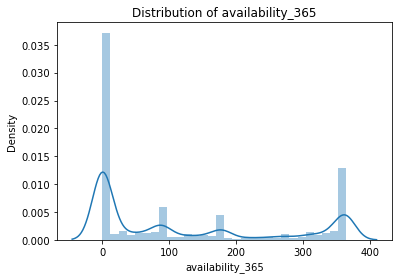

In [38]:
"""
Display the distribution of data in availability_365 column
"""
sns.distplot(dfDirty.availability_365, bins = 30)
plt.xlabel('availability_365')
plt.title("Distribution of availability_365")
# plt.ylabel('Distribution', fontsize=16)
plt.show()

It is found that the data distribution is seriously uneven

In [39]:
"""
Calculate the distribution of the data and see how much data in each category of the availability_365 column
"""
x20 = pd.DataFrame(dfDirty["availability_365"].value_counts().rename_axis('availability_365').reset_index(name='counts'))
x21 = x20.sort_values(["availability_365"], ascending=True)
x21

,availability_365,counts
0,0,33246
17,1,303
54,2,124
34,3,165
26,4,218
...,...,...
23,361,223
9,362,609
7,363,1123
2,364,2504


Normalize x21 dataframe, make this dataframe fit a normal distribution. The data is then resampled based on this normalized quantity.

In [40]:
"""
Using Boxcox normalization to normalize the counts.
"""
x_normal = stats.boxcox(x21.counts)[0]

D:\Anaconda\envs\new\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


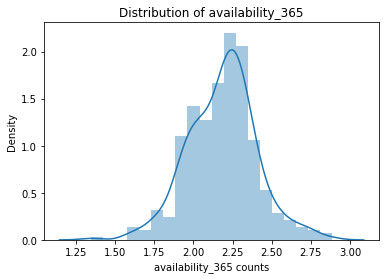

In [41]:
"""
After adjustment, the counts meet the normal distribution
"""
# Draw the distplot
sns.distplot(x_normal)
plt.xlabel("availability_365 counts")
plt.title("Distribution of availability_365")
plt.show()

After normalization, the data is in the interval of 1-3 and cannot be resampled. The data needs to be normalized and scaling. I will use MIN-MAX scaling method to scale the data to 0-6 without changing the distribution.

In [42]:
"""
Using Min-Max method to scale the data to 0-6 withoud changing the original distribution.
"""
k = (6-0)/(max(x_normal) - min(x_normal))
transform = [ 0 + k*(x - min(x_normal)) for x in x_normal]

In [43]:
"""
Resample the data according to the normalized values above
"""

# Create an empty dataframe
dfDirtyUnderSampling = pd.DataFrame(columns = dfDirty.columns)

# Add resampled dataframe to the empty dataframe created above
for i in range(366):
#     if i > 10 and i < 22:
#         print(transform[i])
#         dfTemp = dfDirty[dfDirty["availability_365"] == i].sample(n = int(transform[i])+40)
#         dfDirtyUnderSampling = dfDirtyUnderSampling.append(dfTemp, ignore_index=True)
#     else:
    dfTemp = dfDirty[dfDirty["availability_365"] == i].sample(n = int(transform[i]),random_state=1)
    dfDirtyUnderSampling = dfDirtyUnderSampling.append(dfTemp, ignore_index=True)

D:\Anaconda\envs\new\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


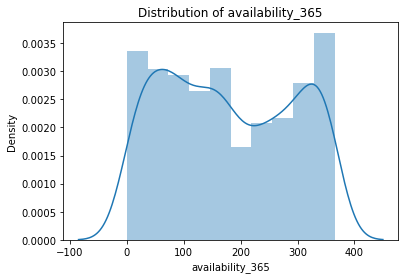

In [44]:
"""
After data tranformation, display the distribution of data in availability_365 column
"""
sns.distplot(dfDirtyUnderSampling.availability_365, bins = 10)
plt.xlabel("availability_365")

plt.title("Distribution of availability_365")
# plt.ylabel('Distribution', fontsize=16)
plt.show()

Now the distribution of availability_365 is much better than original one.

###  Data Transformation 

> - After sampling, I will perform feature selection method on the data to find out which features have a significant impact on the rental situation
>> 1. Using the dataframe.info() method, it is found that the type of the data column is wrong. For example, the availability_365 column should be a number, but in dataframe it is an object, therefore the format needs to be converted.
>> 2. Feature selection also requires that the data must be numeric, so the non-numeric columns are transformed
>> 3. Since the feature selection method requires that the data cannot have NaN values, I need to check if there are NaN values. There are more than 200 empty values in 9 columns of data, because there are not many, I choose to delete them

In [45]:
name = ["host_is_superhost","host_identity_verified","latitude", "longitude", 
        "property_type","room_type","accommodates","bedrooms", "beds", "minimum_nights", "maximum_nights",
       "availability_365","number_of_reviews","review_scores_rating","review_scores_accuracy", "review_scores_cleanliness",
       "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value","Boroughs",
        "daily_cases_rate_rolling_average"]

In [46]:
"""
Remove unimportant columns list host_id, id etc. 
"""
dfDirtyUnderSamplingFilter = dfDirtyUnderSampling[name]

In [47]:
"""
Check the type of each column
"""
dfDirtyUnderSamplingFilter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_is_superhost                 1012 non-null   object 
 1   host_identity_verified            1012 non-null   object 
 2   latitude                          1012 non-null   float64
 3   longitude                         1012 non-null   float64
 4   property_type                     1012 non-null   object 
 5   room_type                         1012 non-null   object 
 6   accommodates                      1012 non-null   object 
 7   bedrooms                          944 non-null    float64
 8   beds                              999 non-null    float64
 9   minimum_nights                    1012 non-null   object 
 10  maximum_nights                    1012 non-null   object 
 11  availability_365                  1012 non-null   object 
 12  number

In [48]:
"""
Some numeric columns are stored as object which is wrong.
So I convert these columns to numeric columns
"""
dfDirtyUnderSamplingFilter["accommodates"] =  dfDirtyUnderSamplingFilter["accommodates"].apply(pd.to_numeric)
dfDirtyUnderSamplingFilter["minimum_nights"] =  dfDirtyUnderSamplingFilter["minimum_nights"].apply(pd.to_numeric)
dfDirtyUnderSamplingFilter["maximum_nights"] =  dfDirtyUnderSamplingFilter["maximum_nights"].apply(pd.to_numeric)
dfDirtyUnderSamplingFilter["availability_365"] =  dfDirtyUnderSamplingFilter["availability_365"].apply(pd.to_numeric)
dfDirtyUnderSamplingFilter["number_of_reviews"] =  dfDirtyUnderSamplingFilter["number_of_reviews"].apply(pd.to_numeric)

C:\Users\lingc\AppData\Local\Temp/ipykernel_373040/2455454480.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDirtyUnderSamplingFilter["accommodates"] =  dfDirtyUnderSamplingFilter["accommodates"].apply(pd.to_numeric)
C:\Users\lingc\AppData\Local\Temp/ipykernel_373040/2455454480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDirtyUnderSamplingFilter["minimum_nights"] =  dfDirtyUnderSamplingFilter["minimum_nights"].apply(pd.to_numeric)
C:\Users\lingc\AppData\Local\Temp/ipykernel_373040/245545448

In [49]:
"""
Check if the type of column is converted successfully
"""
dfDirtyUnderSamplingFilter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_is_superhost                 1012 non-null   object 
 1   host_identity_verified            1012 non-null   object 
 2   latitude                          1012 non-null   float64
 3   longitude                         1012 non-null   float64
 4   property_type                     1012 non-null   object 
 5   room_type                         1012 non-null   object 
 6   accommodates                      1012 non-null   int64  
 7   bedrooms                          944 non-null    float64
 8   beds                              999 non-null    float64
 9   minimum_nights                    1012 non-null   int64  
 10  maximum_nights                    1012 non-null   int64  
 11  availability_365                  1012 non-null   int64  
 12  number

In [50]:
"""
Convert Non-Numeric Column to Numeric column

Convert f for false to 0, t for true to 1
"""

dfDirtyUnderSamplingFilter["host_is_superhost"].replace({"f": 0, "t": 1}, inplace=True)
dfDirtyUnderSamplingFilter["host_identity_verified"].replace({"f": 0, "t": 1}, inplace=True)

D:\Anaconda\envs\new\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [51]:
"""
Convert Non-Numeric Column to Numeric column

Convert the property_type to the counts
"""
x200 = pd.DataFrame(dfDirtyUnderSamplingFilter["property_type"].value_counts().rename_axis('property_type').reset_index(name='counts'))
type1 = list(x200.property_type)
counts1 = list(x200.counts)
dic1 = {}
# Create a dictionary, key = property_type, value:  the value that will be replaced
for i in range(len(type1)):
    dic1[type1[i]] = counts1[i]

In [52]:
dfDirtyUnderSamplingFilter["property_type"].replace(dic1, inplace=True)

In [53]:
"""
Convert Non-Numeric Column to Numeric column

Replace the room_type to its count value
"""
x201 = pd.DataFrame(dfDirtyUnderSamplingFilter["room_type"].value_counts().rename_axis('room_type').reset_index(name='counts'))
type2 = list(x201.room_type)
counts2 = list(x201.counts)
dic2 = {}
# Create a dictionary, key = room_type, value:  the value that will be replaced
for i in range(len(type2)):
    dic2[type2[i]] = counts2[i]

In [54]:
dfDirtyUnderSamplingFilter["room_type"].replace(dic2, inplace=True)

In [56]:
"""
Convert Non-Numeric Column to Numeric column

Replace the Boroughs to its count value
"""

x202 = pd.DataFrame(dfDirtyUnderSamplingFilter["Boroughs"].value_counts().rename_axis('Boroughs').reset_index(name='counts'))
type3 = list(x202.Boroughs)
counts3 = list(x202.counts)
dic3 = {}
# Create a dictionary, key = Boroughs, value:  the value that will be replaced
for i in range(len(type3)):
    dic3[type3[i]] = counts3[i]

In [57]:
dfDirtyUnderSamplingFilter["Boroughs"].replace(dic3, inplace=True)
df123 = dfDirtyUnderSamplingFilter

In [58]:
"""
Find out how many missing values exist in each column
"""

# Count the number of missing values in each column and create a new Dataframe based on the results
dfDirtyCheck2 = pd.DataFrame(df123.isnull().sum().rename_axis('Column_Name').
                             reset_index(name='NaN_Counts'))

# Sort this new Dataframe from largest to smallest according to column "NaN_Counts" column
dfDirtyCheck2 = dfDirtyCheck2.sort_values(["NaN_Counts"], ascending=False)
dfDirtyCheck2.head(5) 

# print number of NaNs in each column
for i in name:
    print("Column \"%s\" has %d NaN values." % (list(dfDirtyCheck2[dfDirtyCheck2["Column_Name"] == i].Column_Name)[0],
                                           list(dfDirtyCheck2[dfDirtyCheck2["Column_Name"] == i].NaN_Counts)[0]))

Column "host_is_superhost" has 0 NaN values.
Column "host_identity_verified" has 0 NaN values.
Column "latitude" has 0 NaN values.
Column "longitude" has 0 NaN values.
Column "property_type" has 0 NaN values.
Column "room_type" has 0 NaN values.
Column "accommodates" has 0 NaN values.
Column "bedrooms" has 68 NaN values.
Column "beds" has 13 NaN values.
Column "minimum_nights" has 0 NaN values.
Column "maximum_nights" has 0 NaN values.
Column "availability_365" has 0 NaN values.
Column "number_of_reviews" has 0 NaN values.
Column "review_scores_rating" has 247 NaN values.
Column "review_scores_accuracy" has 249 NaN values.
Column "review_scores_cleanliness" has 248 NaN values.
Column "review_scores_checkin" has 249 NaN values.
Column "review_scores_communication" has 248 NaN values.
Column "review_scores_location" has 249 NaN values.
Column "review_scores_value" has 249 NaN values.
Column "Boroughs" has 0 NaN values.
Column "daily_cases_rate_rolling_average" has 0 NaN values.


The above result shows that there are nine columns with missing values, I decided to delete these empty values ​​directly

In [59]:
"""
Remove missing values based on the result above
"""
df123.dropna(subset = ["bedrooms"], inplace=True)
df123.dropna(subset = ["beds"], inplace=True)
df123.dropna(subset = ["review_scores_rating"], inplace=True)
df123.dropna(subset = ["review_scores_accuracy"], inplace=True)
df123.dropna(subset = ["review_scores_cleanliness"], inplace=True)
df123.dropna(subset = ["review_scores_checkin"], inplace=True)
df123.dropna(subset = ["review_scores_communication"], inplace=True)
df123.dropna(subset = ["review_scores_location"], inplace=True)
df123.dropna(subset = ["review_scores_value"], inplace=True)

D:\Anaconda\envs\new\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Feature Selection

In [60]:
"""
According to the requirements of the machine learning algorithm, the features and targets need to be divided into two data frames
"""

# X stores features
X = df123.drop(["availability_365"], axis=1, inplace=False)
# y stores targets
y = df123[["availability_365"]]

In [61]:
"""
Create a selector. 
Since this is a regression problem, and the features are all numerical variables, I will use 'f_regression' function.
Keep the 7 features with the highest degree of correlation
"""
# Use f_regression function, because it is a regression problem
# Use k=7 to keep the 7 features with the highest degree of correlation
selector = SelectKBest(score_func=f_regression, k=7)

# Fit the data
modelOutput = selector.fit(X, y)

# In order to better display the results, decided to create a data frame
name1 = X.columns
featureImportance = pd.DataFrame({
    # Dataframe Columns
    "feature": name1,
    # Score of correlation for each feature
    "score": modelOutput.scores_,
    # P-Value for each feature
    "pvalue": modelOutput.pvalues_,
    # True means select the feature, False means give up, or return the index
    "select": modelOutput.get_support()
})
featureImportance.sort_values("score", ascending=False)

D:\Anaconda\envs\new\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,feature,score,pvalue,select
6,accommodates,19.541759,0.000011,True
10,maximum_nights,11.059630,0.000928,True
8,beds,11.004249,0.000956,True
19,Boroughs,9.731320,0.001886,True
7,bedrooms,5.999600,0.014553,True
1,host_identity_verified,3.945310,0.047392,True
5,room_type,3.767048,0.052673,True
11,number_of_reviews,3.032991,0.082027,False
20,daily_cases_rate_rolling_average,1.395122,0.237943,False
0,host_is_superhost,1.174887,0.278773,False


In [62]:
selected = featureImportance[featureImportance["select"] == True].sort_values("score", ascending=False)

selected

,feature,score,pvalue,select
6,accommodates,19.541759,0.000011,True
10,maximum_nights,11.059630,0.000928,True
8,beds,11.004249,0.000956,True
19,Boroughs,9.731320,0.001886,True
7,bedrooms,5.999600,0.014553,True
1,host_identity_verified,3.945310,0.047392,True
5,room_type,3.767048,0.052673,True


In [63]:
"""
Get the selected features
"""
selectedFeature = list(selected.feature)
selectedFeature

['accommodates',
 'maximum_nights',
 'beds',
 'Boroughs',
 'bedrooms',
 'host_identity_verified',
 'room_type']

In [64]:
# X stores features
X1 = df123[selectedFeature]
# y stores targets
y1 = df123[["availability_365"]]

In [68]:
"""
Call the LassoCV function and perform cross-validation using cv = 5
"""
model_lasso = LassoCV(alphas = [0.1,1, 0.001, 0.0005, 0.05], cv = 5).fit(X1, y1)
# Print the results
for i in range(len(list(X1.columns))):
    print("The coefficient of feature: \"%s\" is %.2f" %(list(X1.columns)[i], model_lasso.coef_[i]))

The coefficient of feature: "accommodates" is 10.74
The coefficient of feature: "maximum_nights" is 0.02
The coefficient of feature: "beds" is 0.24
The coefficient of feature: "Boroughs" is 0.24
The coefficient of feature: "bedrooms" is -7.83
The coefficient of feature: "host_identity_verified" is 3.64
The coefficient of feature: "room_type" is -0.02


D:\Anaconda\envs\new\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 2. The Executive Briefing

## 2.1 Executive Summary (Summary of your briefing creating a summary of each of the sections below, 200-300 words)

整体思路：挑选对租房影响最大的几个特征。 如何判断租房的好坏：availability_365这一列，365天内租出的天数数量，可以反映租房的好坏。 

## 2.2 Background (problem framing, 300-400 words)

352个字

1. 首先介绍疫情下伦敦的情况。着重描述2020年的。比如疫情扩散的非常快，哪些区域收到了极大的影响。无论是经济上还是生活上都对英国人民造成了极大的冲击。（1个引用）

2. 然后介绍疫情对伦敦的影响。首先介绍疫情对伦敦或者英国的整体经济、旅游情况的影响（此处1-2个引用），再说疫情对伦敦房地产、租赁相关的影响（1-2个引用）

3. 在当今疫情的大环境下，如何对Airbnb投资是一个非常值得思考的事情。由于疫情，市场的大环境可能已经悄然发生了转变（举例如何转变1个引用），所以不能用传统的老一套思维对房屋租赁市场进行投资，这可能会造成严重后果，成为一次极其失败的投资。

4. 近年来，人工智能、机器学习领域发展的十分迅速，在各行各业的应用都卓有成效。（1个引用）

5. 本文将通过数据分析、机器学习的方法，以数据为驱动，对疫情下伦敦Airbnb市场的投资提供决策。

## 2.3 Data Analysis (description of the analysis, approach and results, 400-500 words)

### 2.3.1 Dataset introduction

99字

1. **Dataset 1**: "202011listings": Contains all London Airbnb rentals for November 2020. This data has 76,984, 74 columns, and contains Airbnb London records for mid-January 2020. This set of data has more than 70 features, including the number of houses, the number of houses and other data.The distribution of this dataset is uneven, and there are many problems in the data, it requires large amount of data preprocessing processes.

2. **Dataset 2** : "uk-daily-covid-cases-7day-average"：This dataset has 134786 rows and 4 columns. It contains information on Covid cases in various regions of the UK, from 2020 to 2022.(https://hidden-london.com/miscellany/covid-19-in-london/)

                                                  Figure1. The Distribution of Airbnb Houses

![avatar](https://raw.githubusercontent.com/ShengweiDeng/i2p/Data/Map.png?token=GHSAT0AAAAAABRDNSUTH5UD6X7NKGORODQWYPX6BCA)

### 2.3.2 Data analysis

888字。。。。

整体思路：挑选对租房影响最大的几个特征。 如何判断租房的好坏：availability_365这一列，365天内租出的天数数量，可以反映租房的好坏。 

数据预处理流程：

由于有两个数据集，我将首先对两组数据分别进行数据预处理，然后将处理好的两组数据进行合并。合并后继续对合并后的数据进行处理，是它能在后续的分析中表现的更好。

1. 第一组数据处理：首先，先检查数据是否存在空值。经过检查，发现该数据存在空值并且有四列数据全部为空值。对于全部为空值的列，我没有别的更好的办法，所以我决定将这全部为空值的四列删除掉。其次，我将从空间上根据记录的经纬度坐标，判断房屋是否都在32个伦敦自治州内。我先将所有的房屋数据绘制在了一个地图上，并且绘制了32个自治州的边界。从地图上整体来看，发现绝大多数房屋都在自治州边界内。然后我使用了GeoSeries.contains() method来看具体哪些房屋不属于伦敦的32个自治州。根据结果，发现有18条数据不在范围内，由于数量不大，我决定直接删除掉这些数据。

2. 第二组数据处理：首先，先检查数据是否存在空值。经过检查，发现数据存在空值，并且有一列所有数据都为空值。对于这个全是空值的列，我决定直接删除。然后，由于这个数据包含了2020年到2022年伦敦所有地区的数据，所以我需要做一个Data Transformation来对数据进行筛选。为了匹配第一组数据，我将只保留2020年11月，伦敦32个自治州的疫情数据。

3. 合并第一组和第二组数据框

4. 对合并后的数据进行data transformation，使得数据能适应后续的分析。首先，我对数据中的“availability_365”这一列进行可视化分析，发现数据分布的极为不均衡，完全不属于正态分布。所以我决定使用欠采样思路对数据进行重新采样。在重新采样前，我需要计算每一个类型采多少样本。首先，我使用了"stats.boxcox" method对数据进行Normalization。将每一类数据的数量调整到了1至3的区间内。这一步骤完毕之后，数据呈现了正态分布。但是由于我需要确定重新采样的数量，计算得出的结果是在1至3区间内，假如直接按照这个数据进行采样样本数量太少。所以我决定继续使用“MIN-MAX scaling”方法，在保留原始分布的前提下，将数据调整到0到6区间内。随后按照这些数据通过dataframe.sample方法对数据框重新进行采样。

5. 对误判为non-numeric的列进行类型转化，对原本就是non-numeric的列，根据它的frequency转化为numeric的列。

**图片对比**： 数据处理前分布，数据处理后分布

![avatar](https://raw.githubusercontent.com/ShengweiDeng/i2p/main/Before.png?token=GHSAT0AAAAAABRDNSUSWVLA4DH5UGHFJM3KYPX6FQA)

![avatar](https://raw.githubusercontent.com/ShengweiDeng/i2p/main/after.png?token=GHSAT0AAAAAABRDNSUTXKBD644KUV2IM4ZIYPX6GOA)

### 2.3.3 Approach

300字

1. 使用了“sklearn.feature_selection”中的“SelectKBest”方法，对数据集进行特征选择。它的作用是给所有特征进行打分，然后选择与目标最相关的k个特征。“SelectKBest”这个方法提供了几种评价特征的方法，涵盖了分类问题、回归问题等。由于目标“availability_365”365天内总共租出的天数是连续的，并且我希望通过特征计算Airbnb可以租出的天数，所以这是一个回归问题。 我决定使用“f_regression function”这个评价特征的方法对数据进行特征的选择。“f_regression function”是计算每个回归变量与目标之间的相关性并将其转换为F分数，然后转换为p值来进行特征的选择的。

2. LassoCV对数据进行回归分析。LASSO是由1996年Robert Tibshirani首次提出，全称Least absolute shrinkage and selection operator。该方法是一种压缩估计。（引用+1）    由于目标是找出最影响房屋出租的特征，所以这里我只需要得出每个特征的回归系数即可。

### 2.3.4 Results

1. 对下面这个表进行描述



2. LassoCV的结果 回归模型

The coefficient of feature: "accommodates" is 10.74
（10.74的系数，说明accommodates增加一个，availability_365增加10.74）

The coefficient of feature: "maximum_nights" is 0.02
The coefficient of feature: "beds" is 0.24
The coefficient of feature: "bedrooms" is -7.83
前面都是numeric好解释


后面这些non-numeric的：



原始数据是f，t（false，true），我给他转化成0,1. 所以你看这个系数是正的，所以说明host_identity_verified越靠近1，越好。所以就是说房东有认证，更好组。
The coefficient of feature: "host_identity_verified" is 3.64


这个我是根据他们在数据中出现的数量来进行转化的。 下面这两个是我替换的值。 就是对这些类别做了一个group by count，然后将下面对应的数值替换原来的文本。懂了没 不懂微信我

然后就好分析了啊，你看，Borough这个特征的系数是正的，说明数量越大越好。然后根据下面的dic3，右边数据越大越好，然后“Westminster”这个区的数最大，那就是说在这里的租的更好。（但是由于系数很低，所以emm，也别太绝对）
The coefficient of feature: "Boroughs" is 0.24

dic2是room type的，是负的，room type越小，因变量越大。说明越小越好（shared room是13最小），所以说明shared room可能最受欢迎
The coefficient of feature: "room_type" is -0.02



In [71]:
dic2  #:room_type

{'Entire home/apt': 691,
 'Private room': 292,
 'Hotel room': 16,
 'Shared room': 13}

In [72]:
dic3 #:Boroughs

{'Westminster': 146,
 'Kensington and Chelsea': 103,
 'Camden': 89,
 'Wandsworth': 64,
 'Tower Hamlets': 63,
 'Hackney': 61,
 'Hammersmith and Fulham': 57,
 'Lambeth': 57,
 'Islington': 54,
 'Southwark': 49,
 'Brent': 27,
 'Newham': 25,
 'Barnet': 20,
 'Ealing': 20,
 'Waltham Forest': 17,
 'Croydon': 17,
 'Haringey': 16,
 'Hounslow': 14,
 'Lewisham': 14,
 'Greenwich': 13,
 'Richmond upon Thames': 12,
 'Merton': 9,
 'City of London': 9,
 'Bromley': 9,
 'Kingston upon Thames': 8,
 'Enfield': 8,
 'Sutton': 8,
 'Barking and Dagenham': 6,
 'Hillingdon': 6,
 'Bexley': 5,
 'Redbridge': 3,
 'Havering': 2,
 'Harrow': 1}

                                                  Table 1. The Result of Feature Selection

| feature | score | pvalue | select |
| :------| ------: | :------: | :------: |
| accommodates | 19.541759 | 0.000011 | True |
| maximum_nights | 11.059630 | 0.000928 | True |
| beds | 19.541759 | 0.000956 | True |
| Boroughs | 9.731320 | 0.001886 | True |
| bedrooms | 5.999600 | 0.014553 | True |
| host_identity_verified | 3.945310 | 0.047392 | True |
| room_type | 3.767048 | 0.052673 | True |

## 2.4 Conclusion (what was learned, limitations and what are your recommendations, 300-400 words)

468个字

**Recommendations**

1. 由于疫情，市场的大环境可能已经悄然发生了转变（举例如何转变1个引用），所以不能用传统的老一套思维对房屋租赁市场进行投资，这可能会造成严重后果，成为一次极其失败的投资。

2. 由于疫情情况变幻莫测，形势不好判断，我建议CEO以数据为驱动来进行投资。


2. 我建议在当今疫情环境下，对Airbnb的市场按照我分析的结果进行投资（因为我的报告就是以数据为支撑，通过对数据进行分析，才得出的结论）。将上面的results复制一部分粘贴到这里。

3. Limitations。建议考虑这些limitations，在未来我会将这些问题更好的解决，使模型的精确度更高。


**What was learned:**

1. Programming for spatial analysis
2. 数据预处理的方法、如何对空间数据进行处理
3. 数据可视化、空间数据可视化
4. 数据分析、特征选择、机器学习模型
5. Python编程语言的学习
6. 业务层面，如何为ceo提供决策等，发现市场痛点。。。。

**Limitations** 通用的随便编几条吧。

1. 数据分布极为不均衡，虽然做了数据预处理，并且分布得到了极大的改善，但是仍然没有做的尽善尽美，需要在后续提升
2. 模型的选择不太灵活。需要在未来更多的充实自己
3. 模型的参数可能没有调到最优。后续可以继续学习调优算法，为我的模型进行调优，达到更加精确的结果。


## 2.5 References